### Importing Libraries and Data

In [1]:
# We import the relevant libraries.
%load_ext autoreload
%autoreload 2

import keras
import nltk
import plot
import preprocess
import re,string,unicodedata
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, plot_confusion_matrix
from string import punctuation
from keras.models import Sequential
from keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout
from tensorflow.keras.layers import GlobalMaxPool1D
from tensorflow.keras.models import Model
from collections import Counter
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
)

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maxladegaard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/maxladegaard/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/maxladegaard/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
# Load the data.
test_data = pd.read_csv("Corona_NLP_test.csv")
train_data = pd.read_csv("Corona_NLP_train.csv",encoding = 'ISO-8859-1')

### EDA

In [3]:
# Combining the test and the training data to explore the full dataset.
combined_data = pd.concat([train_data,test_data])

# Renaming 'Tweet' column to 'OriginalTweet'.
combined_data.rename(columns ={'OriginalTweet': 'Tweet'}, inplace = True)

In [4]:
# Missing values for each column.
train_data.isna().sum(axis = 0)

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [5]:
# See the data types.
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44955 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserName    44955 non-null  int64 
 1   ScreenName  44955 non-null  int64 
 2   Location    35531 non-null  object
 3   TweetAt     44955 non-null  object
 4   Tweet       44955 non-null  object
 5   Sentiment   44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.4+ MB


In [6]:
# Number of Tweets per annotated sentiment; Neutral, Positive, Extremely Negative, Negative, Extremely Positive.
sent_ditr = combined_data\
            .groupby('Sentiment')\
            .count()['Tweet']\
            .reset_index()\
            .sort_values(by='Tweet', ascending=False)
sent_ditr.style.background_gradient(cmap='spring')

,Sentiment,Tweet
4,Positive,12369
2,Negative,10958
3,Neutral,8332
1,Extremely Positive,7223
0,Extremely Negative,6073


In [7]:
# Looking at the top 100 Locations.
top100_location = combined_data.Location.value_counts(sort=True, ascending=False)[1:101]
top100_location = pd.DataFrame(top100_location)
print(top100_location)

                             Location
London, England                   568
London                            565
New York, NY                      429
Washington, DC                    411
United Kingdom                    355
...                               ...
North West, England                40
Calgary, Alberta                   40
Dublin                             39
Dubai, United Arab Emirates        39
Orlando, FL                        38

[100 rows x 1 columns]


In [8]:
# Transforming 'TweetAt' data type to dateTime for combined_data, train_data, test_data.
combined_data['TweetAt'] = pd.to_datetime(combined_data['TweetAt'])
train_data['TweetAt'] = pd.to_datetime(train_data['TweetAt'])
test_data['TweetAt'] = pd.to_datetime(test_data['TweetAt'])

/Users/maxladegaard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '16-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/maxladegaard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '17-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/maxladegaard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '18-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/maxladegaard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: User

In [9]:
# Creating object tweets_per_day for data.
tweets_per_day = preprocess.strftime_data(combined_data['TweetAt'], "%m-%d")
tweets_per_day_train = preprocess.strftime_data(train_data['TweetAt'], "%m-%d")
tweets_per_day_test = preprocess.strftime_data(test_data['TweetAt'], '%m-%d')

print(tweets_per_day)

    index  counts
0   01-04     630
1   02-03       4
2   02-04     954
3   03-03       4
4   03-04     810
5   03-13    1233
6   03-14     614
7   03-15     519
8   03-16    1128
9   03-17    1977
10  03-18    2742
11  03-19    3215
12  03-20    3448
13  03-21    2653
14  03-22    2114
15  03-23    2062
16  03-24    1480
17  03-25    2979
18  03-26    1277
19  03-27     345
20  03-28      23
21  03-29     125
22  03-30      87
23  03-31     316
24  04-03       8
25  04-04     767
26  04-13    1428
27  04-14     284
28  05-03       6
29  05-04    1131
30  06-03       2
31  06-04    1742
32  07-03       7
33  07-04    1843
34  08-03       9
35  08-04    1881
36  09-03      16
37  09-04    1471
38  10-03      54
39  10-04    1005
40  11-03     165
41  11-04     909
42  12-03     685
43  12-04     803


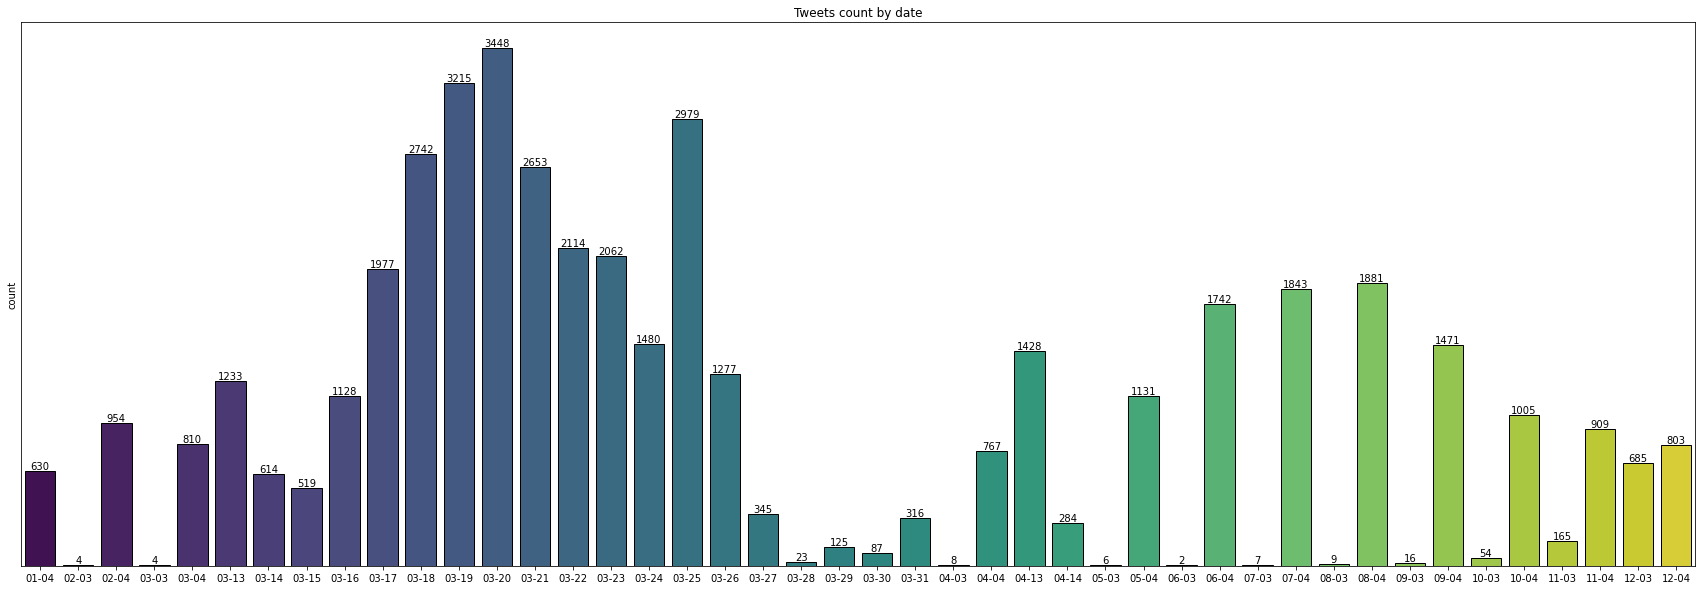

In [10]:
# Visualizing the number of tweets per day for the full time period.
_, ax = plt.subplots(1, 1, figsize=(30, 10))
plot.barplot(
    ax, tweets_per_day,
    x='index',
    y='counts',
    title='Tweets count by date',
)
plt.show()

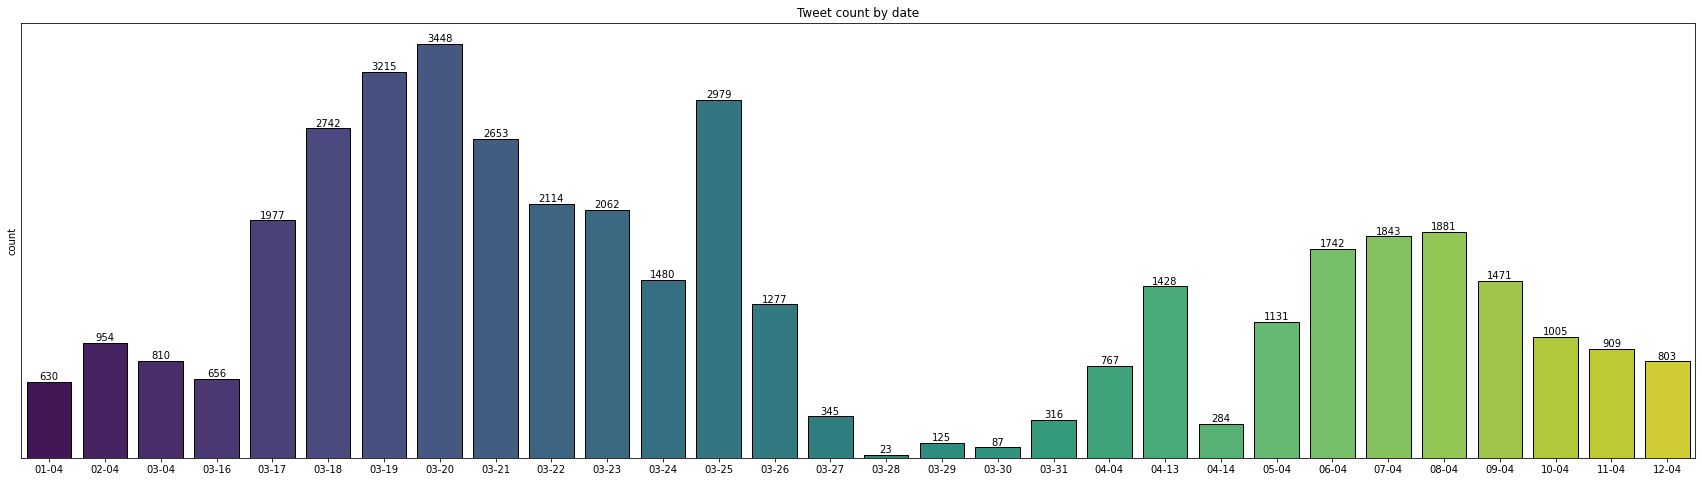

In [11]:
# Visualizing the number of tweets per day for the training data.
_, ax = plt.subplots(1, 1, figsize=(30, 8))
plot.barplot(
    ax, tweets_per_day_train,
    x='index',
    y='counts',
    title='Tweet count by date',
)
plt.show()

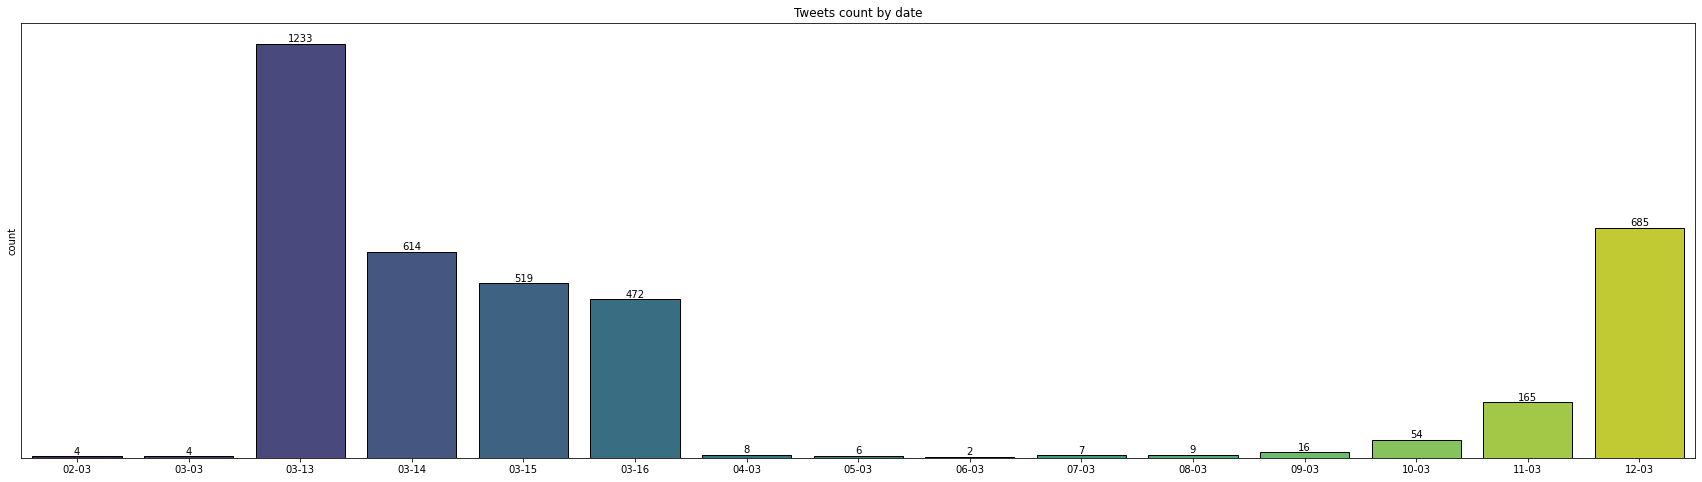

In [12]:
# Visualizing the number of tweets per day for the test data.
_, ax = plt.subplots(1, 1, figsize=(30, 8))
plot.barplot(
    ax, tweets_per_day_test,
    x='index',
    y='counts',
    title='Tweets count by date',
)
plt.show()

In [13]:
# Creating object for tweets_per_country.
tweets_per_country = combined_data['Location'].value_counts().loc[lambda x : x > 100].reset_index(name='counts')

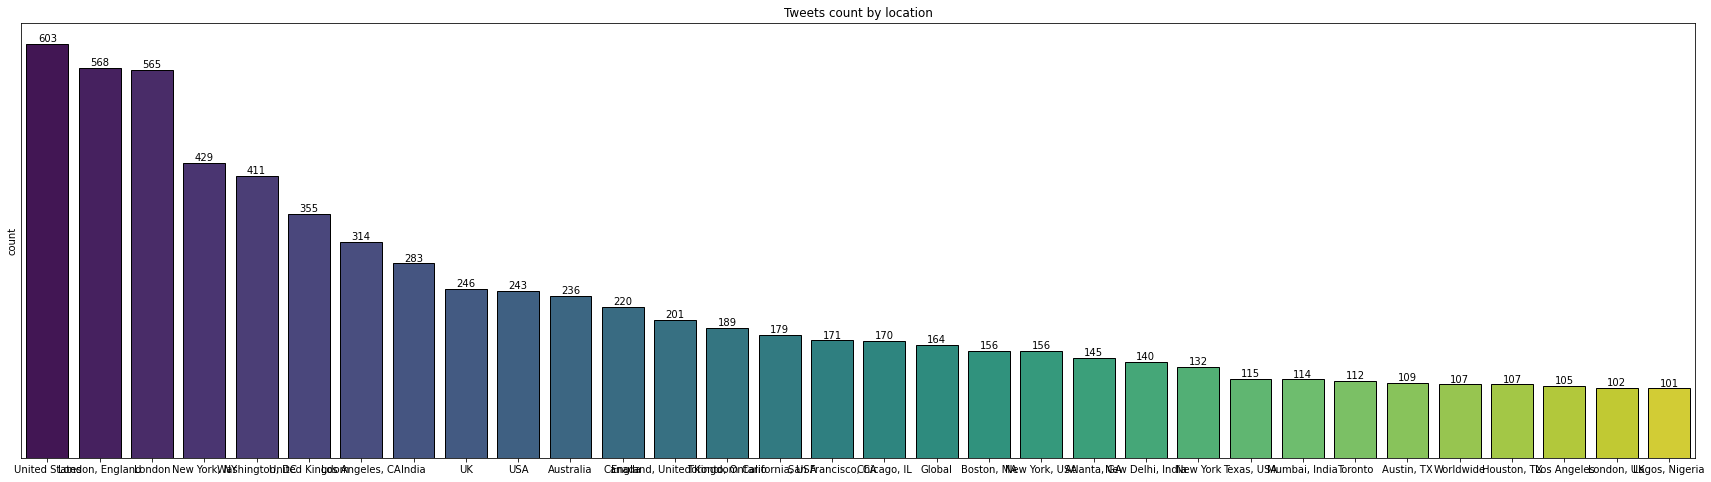

In [14]:
# Visulizing number of tweets per location.
_, ax = plt.subplots(1, 1, figsize=(30, 8))
plot.barplot(
    ax, tweets_per_country,
    x='index',
    y='counts',
    title='Tweets count by location',
)
plt.show()

In [15]:
words = []
for row in combined_data['Tweet']:
    words.extend(row.split())

In [16]:
# Pass the split_it list to instance of Counter class.
counter = Counter(words)
  
# most_common(20) produces the 20 most common words.
most_occur = counter.most_common(20)
  
print(most_occur)

[('the', 44192), ('to', 40961), ('and', 25414), ('of', 23270), ('a', 19641), ('in', 19354), ('for', 14586), ('#coronavirus', 13245), ('is', 12829), ('are', 11852), ('on', 9888), ('I', 9409), ('you', 8489), ('at', 8179), ('with', 6538), ('have', 6517), ('that', 6466), ('prices', 6410), ('this', 6409), ('food', 6023)]


### Preprocessing

In [17]:
# Renaming coulm 'OriginalTweet' to 'Tweet' for train and test data.
train_data.rename(columns={'OriginalTweet': 'Tweet'}, inplace=True)
test_data.rename(columns={'OriginalTweet': 'Tweet'}, inplace=True)
train_data.head()

,UserName,ScreenName,Location,TweetAt,Tweet,Sentiment
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [18]:
test_data.head()

,UserName,ScreenName,Location,TweetAt,Tweet,Sentiment
0,1,44953,NYC,2020-02-03,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",2020-02-03,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,2020-02-03,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,2020-02-03,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",2020-03-03,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [19]:
# Preprocessing the data based on the preprocessing function defined in the preprocess.py file.
train_data = preprocess.tweets(train_data)
test_data = preprocess.tweets(test_data)

/Users/maxladegaard/Desktop/Sentiment Analysis/preprocess.py:36: FutureWarning: The default value of regex will change from True to False in a future version.
  df.Tweet = df.Tweet.str.replace(reg, replace)
/Users/maxladegaard/Desktop/Sentiment Analysis/preprocess.py:36: FutureWarning: The default value of regex will change from True to False in a future version.
  df.Tweet = df.Tweet.str.replace(reg, replace)


In [20]:
# Giving the sentiments value numbers.

sentiment_map = {
    'Extremely Negative': -2,
    'Negative': -1,
    'Neutral': 0,
    'Positive': 1,
    'Extremely Positive': 2,
}

binary_sentiment_map = {
    'Extremely Negative': 0,
    'Negative': 0,
    'Neutral': 1,
    'Positive': 1,
    'Extremely Positive': 1,
}

train_data['sentiment'] = train_data['Sentiment'].map(sentiment_map, na_action=None)
train_data['sentiment_bin'] = train_data['Sentiment'].map(binary_sentiment_map, na_action=None)
test_data['sentiment'] = test_data['Sentiment'].map(sentiment_map, na_action=None)
test_data['sentiment_bin'] = test_data['Sentiment'].map(binary_sentiment_map, na_action=None)

In [21]:
# Filter in the columns that we need.

include_cols = ['Tweet', 'tokenized_tweets', 'sentiment', 'sentiment_bin']

train = train_data[include_cols]
test = test_data[include_cols]

In [22]:
text_len = preprocess.word_count(train.Tweet)
train = train[text_len > 2]

text_len = preprocess.word_count(test.Tweet)
test = test[text_len > 2]

### EDA After Preprocessing

In [23]:
# See the sentiment count for our training set.

print(train['sentiment'].value_counts())
print(train['sentiment_bin'].value_counts())

 1    11345
-1     9850
 0     7347
 2     6616
-2     5478
Name: sentiment, dtype: int64
1    25308
0    15328
Name: sentiment_bin, dtype: int64


In [24]:
# See the sentiment count for our test set.
print(test["sentiment"].value_counts())
print(test["sentiment_bin"].value_counts())


-1    1040
 1     942
 2     599
 0     598
-2     592
Name: sentiment, dtype: int64
1    2139
0    1632
Name: sentiment_bin, dtype: int64


In [25]:
tokenized_tweets_together_df = []
values_tweets = train['tokenized_tweets'].values

for val in values_tweets:
  tokenized_tweets_together_df.extend(val)

together = Counter(tokenized_tweets_together_df)
together.most_common(10)

[('covid', 10550),
 ('price', 8891),
 ('store', 8212),
 ('supermarket', 7291),
 ('food', 7029),
 ('grocery', 6531),
 ('people', 5583),
 ('consumer', 5016),
 ('shopping', 3366),
 ('online', 3357)]

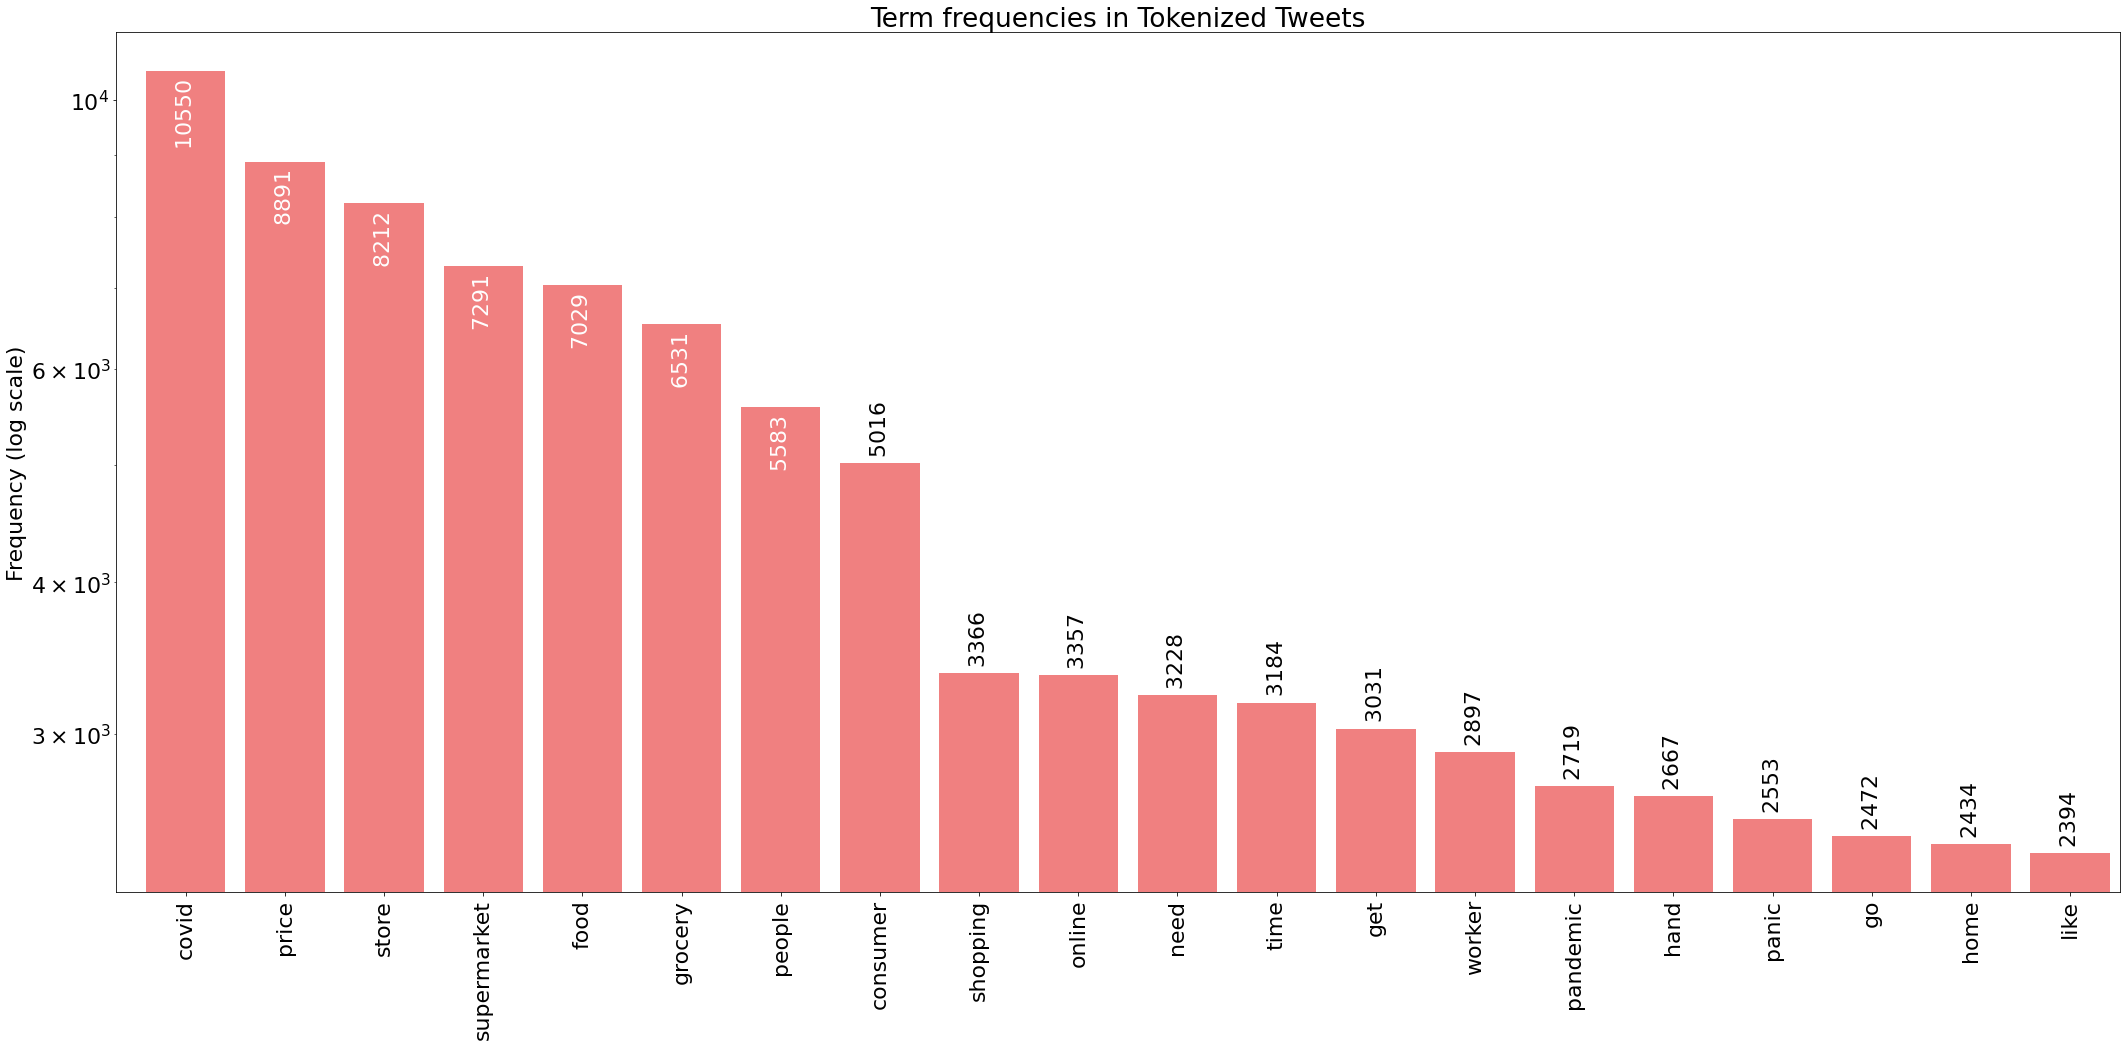

In [26]:
# The most popular words in the tweets.

plt.rcParams.update({'font.size': 22})

y = [count for tag, count in together.most_common(20)]
x = [tag for tag, count in together.most_common(20)]

_, ax = plt.subplots(1, 1, figsize=(30, 15))
ax.bar(x, y, color='lightcoral')
ax.set_title("Term frequencies in Tokenized Tweets")
ax.set_ylabel("Frequency (log scale)")
ax.set_yscale('log')
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(together.most_common(20)):
    ax.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 7 else 'bottom',
             color='white' if i < 7 else 'black')
ax.set_xlim(-0.7, len(x)-0.5)
plt.tight_layout()
plt.show()

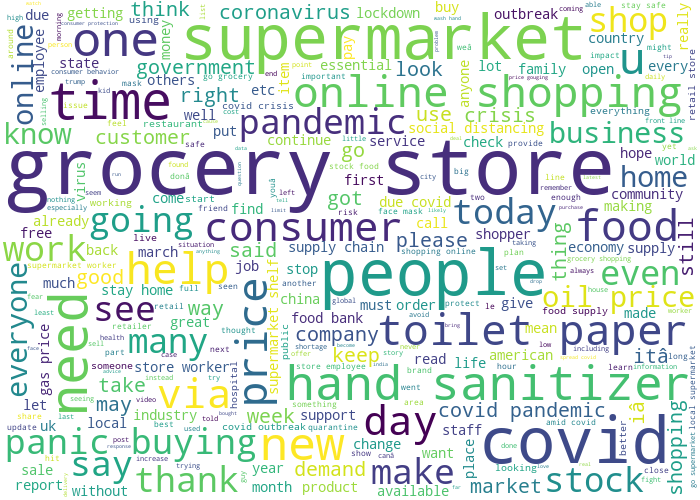

In [27]:
# Create a WordCloud object
long_string = ','.join(list(train_data['tokenized_tweets'].str.join(" ").values))
wordcloud = WordCloud(
    background_color="white",
    relative_scaling=0.5,
    max_words=300,
    width = 700,
    height = 500,
    repeat = False,
    contour_width=3,
    contour_color='steelblue'
)

wordcloud.generate(long_string)
wordcloud.to_image()

### Train-Test Split

In [28]:
# Split the training data into X and Y.
X = train_data['Tweet']
y = train_data['sentiment']

# Split the test data into X and Y.
X_test = test_data['Tweet']
y_test = test_data['sentiment']

In [29]:
# Split the training data into train and validation in case we need validation data.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=27)

In [30]:
# Check the shapes.
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(37041,)
(37041,)
(3798,)
(3798,)


### Multinominal Naive Bayes

In [31]:
# Split the data to test bin-model.
X_train_bin_nb = train["Tweet"]
X_test_bin_nb = test["Tweet"]
# y_train_nb = train["sentiment"]
y_train_bin_nb = train["sentiment_bin"]
# y_test_nb = test["sentiment"]
y_test_bin_nb = test["sentiment_bin"]


In [32]:
# Check the shapes.
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(37041,) (3798,) (37041,) (3798,)


In [33]:
# Check the shapes.
print(X_train_bin_nb.shape, X_test_bin_nb.shape, y_train_bin_nb.shape, y_test_bin_nb.shape)

(40636,) (3771,) (40636,) (3771,)


In [ ]:
nb_bin = Pipeline([
    ('vect',  CountVectorizer()),
    ('sampling', SMOTE(random_state=33)),
    ('clf', MultinomialNB())
])

nb_bin.fit(X_train_bin_nb, y_train_bin_nb)
pred_bin = nb_bin.predict(X_test_bin_nb)

nb_clf = Pipeline([('vect', CountVectorizer()),
                ('sampling', SMOTE(random_state=42)),
                ('clf', MultinomialNB())])

parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'clf__fit_prior': (True, False),
              'clf__alpha': [0, 1]}

# Do grid serach and fit our NB model.
nb = GridSearchCV(nb_clf, parameters, n_jobs=-1)
nb.fit(X_train, y_train)
pred = nb.predict(X_test)

print("best mean cross-validation score: {:.3f}".format(nb.best_score_))
print("best parameters:", nb.best_params_) 

In [ ]:
# Saving the model for future use.
with open('MNB.pickle', 'wb') as f:
    pickle.dump(nb, f)

In [34]:
# Open the previously saved model.
with open('MNB.pickle', 'rb') as f:
    nb = pickle.load(f)

In [35]:
pred_MNB = nb.predict(X_test)

NB classifier of covid tweets - report:

               precision    recall  f1-score   support

          -2     0.4718    0.4949    0.4831       592
          -1     0.4309    0.4256    0.4282      1041
           0     0.6355    0.4168    0.5034       619
           1     0.3961    0.4710    0.4303       947
           2     0.5219    0.5376    0.5296       599

    accuracy                         0.4639      3798
   macro avg     0.4912    0.4692    0.4749      3798
weighted avg     0.4763    0.4639    0.4655      3798



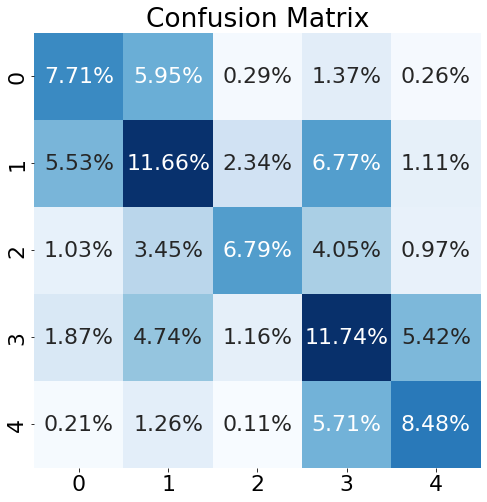

In [36]:
# Generate and print a classification report for the MNB-model.
print('NB classifier of covid tweets - report:\n\n',
    classification_report(y_test, pred_MNB, digits=4,))

_, ax = plt.subplots(1, 1, figsize=(8, 8))
plot.conf_matrix(ax, y_test, pred_MNB)
plt.show()

In [37]:
# Generate and print a confusion matrix for the MNB-model.
cf_matrix = confusion_matrix(y_test, pred_MNB)
print(cf_matrix)

[[293 226  11  52  10]
 [210 443  89 257  42]
 [ 39 131 258 154  37]
 [ 71 180  44 446 206]
 [  8  48   4 217 322]]


### Logistic Regression

In [38]:
# Split the data to test bin-model.
X_train_bin_lr = train["Tweet"]
X_test_bin_lr = test["Tweet"]
#y_train_lr = train["sentiment"]
y_train_bin_lr = train["sentiment_bin"]
#y_test_lr = test["sentiment"]
y_test_bin_lr = test["sentiment_bin"]


In [ ]:
lr_bin = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('sampling', SMOTE(random_state=42)),
                ('clf', LogisticRegression())])

lr_bin.fit(X_train_bin_lr, y_train_bin_lr)
pred_bin_lr = lr_bin.predict(X_test_bin_lr)

lr = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('sampling', SMOTE(random_state=42)),
                ('clf', LogisticRegression())])

lr_parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
                'clf__penalty' : ['l1', 'l2'],
                'clf__solver' : ['liblinear', 'saga', 'newton-cg']},

# Do grid search and fit the logistic regression model.
lr = GridSearchCV(lr, lr_parameters, n_jobs=-1)
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

print("best mean cross-validation score: {:.3f}".format(lr.best_score_))
print("best parameters:", lr.best_params_) 

In [ ]:
# Saving the model for future use.
with open('Logistic Regression.pickle', 'wb') as f:
    pickle.dump(lr, f)

In [40]:
# Open the previously saved model.
with open('Logistic Regression.pickle', 'rb') as f:
    lr = pickle.load(f)

In [41]:
pred_lr = lr.predict(X_test)

LR classifier of covid tweets - report:

               precision    recall  f1-score   support

          -2     0.6079    0.6757    0.6400       592
          -1     0.6005    0.4736    0.5295      1041
           0     0.6218    0.8126    0.7045       619
           1     0.6186    0.5702    0.5934       947
           2     0.6735    0.7162    0.6942       599

    accuracy                         0.6227      3798
   macro avg     0.6244    0.6497    0.6323      3798
weighted avg     0.6211    0.6227    0.6172      3798



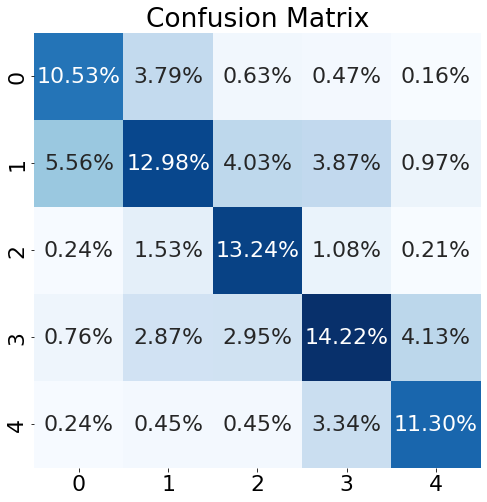

In [42]:
# Generate and print a classfication report for the logistic regression model.
print('LR classifier of covid tweets - report:\n\n', 
    classification_report(y_test, pred_lr, digits=4))

_, ax = plt.subplots(1, 1, figsize=(8, 8))
plot.conf_matrix(ax, y_test, pred_lr)
plt.savefig("NB.png")
plt.show()

### GRU

In [43]:
# Checking the first three rows in the training set
X_train.head(3)

25632            want get coronavirus relief check scammer
22367    16oz liquid cleaner sanitizer aosafety super c...
36453    must observe social distancing regardless inco...
Name: Tweet, dtype: object

In [44]:
# Setting the maximum length.
max_len = np.max(X_train.apply(lambda x :len(x)))
print(max_len)

255


In [45]:
# Initilizing the tokenizer.
tokenizer = Tokenizer()

In [46]:
# Fitting the tokenizer on the training set.
tokenizer.fit_on_texts(list(X_train))

# Creating the varible vocab_length, the number of words in the word_index.
vocab_length = len(tokenizer.word_index) + 1

# Using tokenizer and creating sequences of the train, test, and validation set.
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)
list_tokenized_valid = tokenizer.texts_to_sequences(X_valid)

# Padding the sequences to have the same lenth 
X_train_final = pad_sequences(list_tokenized_train, maxlen=max_len)
X_test_final = pad_sequences(list_tokenized_test, maxlen=max_len)
X_valid_final = pad_sequences(list_tokenized_valid, maxlen=max_len)

In [47]:
# Defining the number of classes.
y_train = to_categorical(y_train, 5)
y_test = to_categorical(y_test, 5)

In [48]:
# Total vocabulary length and maximum lenght of sequence
print("Vocab length:", vocab_length)
print("Max sequence length:", max_len)

Vocab length: 29405
Max sequence length: 255


In [49]:
# Setting embedding dimension to 16.
embedding_dim = 16

In [39]:
# Creating the GRU bidirectional model
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),

# Setting categories to 5 to match the number of classes in the dataset
    tf.keras.layers.Dense(5, activation='softmax')
])
# opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model_gru.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

2022-05-29 16:13:20.160161: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [40]:
# Printing model summary
print(model_gru.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 255, 16)           470480    
                                                                 
 bidirectional (Bidirectiona  (None, 255, 512)         420864    
 l)                                                              
                                                                 
 global_average_pooling1d (G  (None, 512)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 3

In [41]:
# Training the model on the train data with 20 epochs.
history = model_gru.fit(X_train_final, y_train, epochs = 10)

Epoch 1/10
1158/1158 [==============================] - 479s 411ms/step - loss: 1.5092 - accuracy: 0.3137
Epoch 2/10
1158/1158 [==============================] - 478s 413ms/step - loss: 1.1647 - accuracy: 0.5397
Epoch 3/10
1158/1158 [==============================] - 478s 413ms/step - loss: 0.9815 - accuracy: 0.6280
Epoch 4/10
1158/1158 [==============================] - 479s 414ms/step - loss: 0.8078 - accuracy: 0.7021
Epoch 5/10
1158/1158 [==============================] - 496s 428ms/step - loss: 0.6671 - accuracy: 0.7644
Epoch 6/10
1158/1158 [==============================] - 472s 408ms/step - loss: 0.5784 - accuracy: 0.8038
Epoch 7/10
1158/1158 [==============================] - 527s 456ms/step - loss: 0.4927 - accuracy: 0.8396
Epoch 8/10
1158/1158 [==============================] - 493s 426ms/step - loss: 0.4175 - accuracy: 0.8648
Epoch 9/10
1158/1158 [==============================] - 474s 409ms/step - loss: 0.3774 - accuracy: 0.8800
Epoch 10/10
1158/1158 [=======================

In [43]:
# Saving model, now it can be loaded into the enviorment as 'model_gru.h5'.
model_gru.save('GRU Model.h5')

In [50]:
# Load the model if it has been saved previously.
model_gru = load_model('GRU Model.h5')

2022-05-29 22:52:39.478640: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [51]:
pred = np.round(model_gru.predict(X_test_final))

119/119 [==============================] - 13s 102ms/step


119/119 [==============================] - 12s 104ms/step


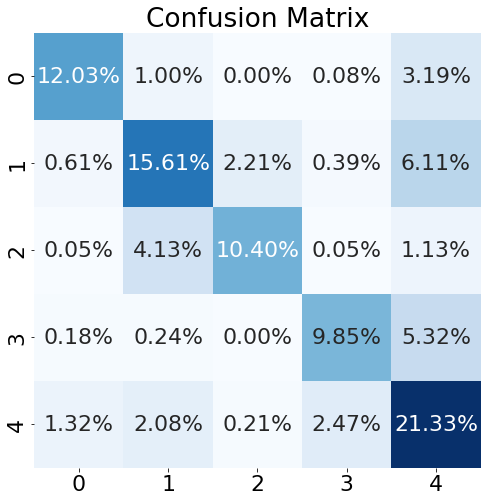

In [53]:
# Creating and printing confusion matrix
y_test_arg = np.argmax(y_test,axis=1)
pred_gru = np.argmax(model_gru.predict(X_test_final),axis=1)

_, ax = plt.subplots(1, 1, figsize=(8, 8))
plot.conf_matrix(ax, y_test_arg, pred_gru)
plt.show()

In [54]:
# Printing classification report
print(classification_report(np.argmax(y_test,1),pred_gru))

              precision    recall  f1-score   support

           0       0.85      0.74      0.79       619
           1       0.68      0.63      0.65       947
           2       0.81      0.66      0.73       599
           3       0.77      0.63      0.69       592
           4       0.58      0.78      0.66      1041

    accuracy                           0.69      3798
   macro avg       0.74      0.69      0.70      3798
weighted avg       0.71      0.69      0.69      3798



### LSTM

In [55]:
# Defining the layers of our LSTM-model.

inp = Input(shape=(max_len, )) 
x   =  Embedding(vocab_length, 16)(inp)
x   =  LSTM(60, return_sequences=True,name='lstm_layer')(x)
x   =  GlobalMaxPool1D()(x)
x   =  Dense(64, activation="relu")(x)
x   =  Dropout(0.2)(x)
x   =  Dense(5, activation="softmax")(x)

In [50]:
# Compiling our LSTM-model.

LSTM_model = Model(inputs=inp, outputs=x)
LSTM_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [51]:
# Training the model.
LSTM_model.fit(X_train_final,y_train, epochs=10)

Epoch 1/10
1158/1158 [==============================] - 93s 79ms/step - loss: 1.1643 - accuracy: 0.5103
Epoch 2/10
1158/1158 [==============================] - 78s 67ms/step - loss: 0.6573 - accuracy: 0.7676
Epoch 3/10
1158/1158 [==============================] - 81s 70ms/step - loss: 0.5009 - accuracy: 0.8362
Epoch 4/10
1158/1158 [==============================] - 75s 64ms/step - loss: 0.4166 - accuracy: 0.8683
Epoch 5/10
1158/1158 [==============================] - 80s 69ms/step - loss: 0.3578 - accuracy: 0.8883
Epoch 6/10
1158/1158 [==============================] - 80s 69ms/step - loss: 0.3080 - accuracy: 0.9063
Epoch 7/10
1158/1158 [==============================] - 73s 63ms/step - loss: 0.2668 - accuracy: 0.9185
Epoch 8/10
1158/1158 [==============================] - 74s 64ms/step - loss: 0.2303 - accuracy: 0.9297
Epoch 9/10
1158/1158 [==============================] - 71s 61ms/step - loss: 0.1986 - accuracy: 0.9414
Epoch 10/10
1158/1158 [==============================] - 78s 68m

In [52]:
# Use this to save the trained model.
LSTM_model.save('LSTM Model.h5')

In [56]:
# Loading a saved model.
LSTM_model = tf.keras.models.load_model('LSTM Model.h5')

In [57]:
# We evaluate our LSTM model on the test set.
LSTM_model.evaluate(X_test_final,y_test)

119/119 [==============================] - 3s 18ms/step - loss: 1.3300 - accuracy: 0.6848


[1.3299763202667236, 0.6848341226577759]

119/119 [==============================] - 3s 18ms/step


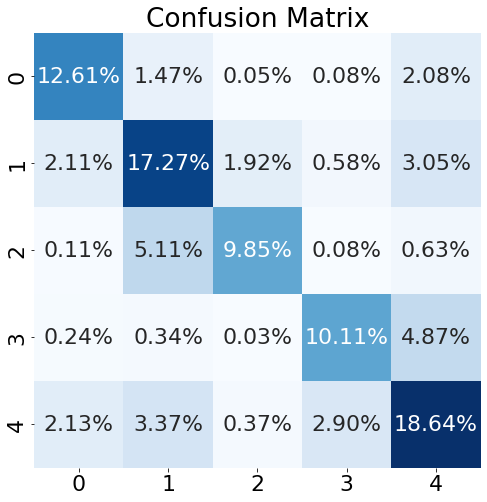

In [58]:
# Creating and printing confusion matrix.
pred2 = np.argmax(LSTM_model.predict(X_test_final),axis=1)

_, ax = plt.subplots(1, 1, figsize=(8, 8))
plot.conf_matrix(ax, y_test_arg, pred2)
plt.show()

In [59]:
# Run and print the classification report.
print(classification_report(np.argmax(y_test,1),pred2))

              precision    recall  f1-score   support

           0       0.73      0.77      0.75       619
           1       0.63      0.69      0.66       947
           2       0.81      0.62      0.70       599
           3       0.74      0.65      0.69       592
           4       0.64      0.68      0.66      1041

    accuracy                           0.68      3798
   macro avg       0.71      0.68      0.69      3798
weighted avg       0.69      0.68      0.69      3798

